In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
sns.set(font_scale=2)

# Multidimensional intervals with nuisiance parameters

## 1. Применение профилирования правдоподобия для оценки доверительных интервалов

**(Повторение 2 семинара)** По теореме Вальда $\frac{(\hat\theta - \theta)^2}{I(\theta)} \rightarrow \mathcal{N}^2(0, 1) \sim \chi^2$, поэтому 

$$2 \log \frac{ L(\hat\theta)}{ L(\theta)} \sim \chi^2_{\mathrm{dim}(\theta)}$$

### Что происходит в случае наличия мешающих параметров

Посмотрим на нормальное распределение: $\mathcal{N}(x | \mu, \sigma^2)$.

Если мы хотим профилировать лайклихуд чисто по дисперсии, то нам нужно избавиться от среднего следующим образом:

$$\mathcal{L}_{max}(\sigma^2) = \max\limits_{\mu} \mathcal{L}(\mu, \sigma^2)$$

В случае нормального распределения это легко расчитывается аналитически:

$$\mathcal{L}_{max}(\sigma^2) = -\frac{n}{2} \log \sigma^2 - \frac{1}{2\sigma^2} \sum\limits_{i} (x_i - \bar{x})^2$$


**Q1: Какая проблема с этим профилем лайклихуда?**

1) У него есть особенность в нуле.

2) Матожидание не равно нулю.

3) Равенство производной лайклихуда нулю неразрешимо относительно \sigma^2 (нет оптимума).

4) Оптимум является смещённой оценкой.

$$\frac{\partial}{\partial \sigma^2} \mathcal{L}_{max}(\sigma^2) = -\frac{n}{2\sigma^2} + \frac{\sum\limits_{i}(x_i - \bar x)^2}{2 \sigma^4}$$

$$\mathrm{E} \frac{\partial}{\partial \sigma^2} \mathcal{L}_{max}(\sigma^2) = - \frac{1}{2\sigma^2} \neq 0$$

## 1.1 Прямое применение профилирования

Рассмотрим проблему где у нас есть N гауссовых распределений: $\mathcal{N}(\mu_i, \sigma^2)$, для каждого распределения у нас есть два измерения: $\{x_{i1}, x_{i2}\}_{i=1}^{N}$.

Построим для него лайклихуд.

In [2]:
mu = np.array([
    0.88, 2.51, 1.74, -6.74, 1.42, -3.34, -2.72, 6.89, 0.67, -4.18, 8.43, 
    0.15, 3.89, 4.52, -4.05, -6.95, -2.61, -6.52, -6.06, 0.92
])
sigma = 1.

X = np.array([
    [-0.31, 3.2, 1.7, -6.67, 3.12, -3.15, -2.11, 6.88, 0.81, -4.25, 8.58, 1.88, 5.18, 3.81, -4.68, -6.58, -2.16, -7.99, -6.48, 0.89],
    [-0.51, 3.57, 2.81, -5.37, 3.74, -3.27, -3.1, 6.53, -2.7, -3.64, 7.08, -1.15, 4.31, 5.86, -4.55, -7.52, -1.13, -7.53, -6.13, 1.33]
])

In [3]:
X.shape[1]

20

In [4]:
sigmas = np.linspace(0.3, 1.4, 1000)
true_likelihood_profiling = [-X.shape[1] * np.log(_sigma**2) -((X - mu)**2).sum() / (2 * _sigma**2) for _sigma in sigmas]
true_likelihood_profiling = np.array(true_likelihood_profiling)

In [5]:
approximate_likelihood_profiling = [-X.shape[1] * np.log(_sigma**2) -((X - X.mean(axis=0))**2).sum() / (2 * _sigma**2) for _sigma in sigmas]
approximate_likelihood_profiling = np.array(approximate_likelihood_profiling)

**Q2: Сколько степеней свободы нужно подставить в chi2 распределение?**

1) 1

2) 2

3) 3

4) 4

In [6]:
from scipy.stats import chi2
alpha = 0.1
cut_level = chi2.ppf(q=1 - alpha, df=1) / 2

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(sigmas**2, np.exp(true_likelihood_profiling) / np.exp(true_likelihood_profiling).max(), c='r')
plt.plot(sigmas**2, np.exp(approximate_likelihood_profiling) / np.exp(approximate_likelihood_profiling).max(), c="g")

plt.twinx()
plt.plot(
    sigmas**2, 
    true_likelihood_profiling - true_likelihood_profiling.max() > -cut_level, 
    c='r', label='{} confidence interval for beta'.format(1 - alpha)
)

plt.plot(
    sigmas**2, 
    approximate_likelihood_profiling - approximate_likelihood_profiling.max() > -cut_level, 
    c='g', label='{} confidence interval for beta'.format(1 - alpha)
)

plt.show()

**Что здесь произошло?**

$$RSS = \sum\limits_{i=1}^{N} \sum\limits_{j=1}^{2} (x_{ij} - \bar{x}_i)^2 \sim \sigma^2 \chi^2_{N}$$


$$\hat\sigma^2 = \frac{RSS}{2N}$$


$$E \hat\sigma^2 = \frac{\sigma^2}{2}$$

## 1. 2 Разделить правдоподобие на части 

**В серьёзной литературе это называется построение маргинальных и условных правдоподобий, но в детали вдаваться не будем (материал со звёздочкой так сказать)**

$$L(\mu, \sigma^2) = L_1(\sigma^2) L_2(\mu, \sigma^2)$$

Такое разложение не единственно, в идеале мы хотим чтобы $L_2$ не зависел от интересующей нас переменной или **зависел слабо**.

**Вернёмся к нашей задаче с N нормальными распределениями**

Сделаем замену переменных:


$$v_i = \frac{x_{i1} - x_{i2}}{\sqrt{2}}$$

$$w_i = \frac{x_{i1} + x_{i2}}{\sqrt{2}}$$

Теперь наше правдоподобие распадается на две части:

$$p(v_i) = \mathcal{N}(v_i | 0, \sigma^2) = L_1(\sigma^2)$$

$$p(w_i) = \mathcal{N}(w_i | \sqrt{2} \mu_i, \sigma^2) = L_2(\mu, \sigma^2)$$

In [9]:
approximate_marginal_likelihood_profiling = [
    -X.shape[1] * np.log(_sigma**2) / 2 - ((np.diff(X, axis=0) / np.sqrt(2))**2).sum() / (2 * _sigma**2) 
    for _sigma in sigmas
]
approximate_marginal_likelihood_profiling = np.array(approximate_marginal_likelihood_profiling)

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(
    sigmas**2, 
    np.exp(true_likelihood_profiling) / np.exp(true_likelihood_profiling).max(), c="r"
)
plt.plot(
    sigmas**2, 
    np.exp(approximate_likelihood_profiling) / np.exp(approximate_likelihood_profiling).max(), c="g"
)
plt.plot(
    sigmas**2, 
    np.exp(approximate_marginal_likelihood_profiling) / np.exp(approximate_marginal_likelihood_profiling).max(), c="y"
)

plt.twinx()
plt.plot(
    sigmas**2, 
    true_likelihood_profiling - true_likelihood_profiling.max() > -cut_level, 
    c='r', label='{} confidence interval for beta'.format(1 - alpha)
)

plt.plot(
    sigmas**2, 
    approximate_likelihood_profiling - approximate_likelihood_profiling.max() > -cut_level, 
    c='g', label='{} confidence interval for beta'.format(1 - alpha)
)

plt.plot(
    sigmas**2, 
    approximate_marginal_likelihood_profiling - approximate_marginal_likelihood_profiling.max() > -cut_level, 
    c='y', label='{} confidence interval for beta'.format(1 - alpha)
)
# plt.legend()
plt.show()

#### Как понять что маргинальный лайклихуд даёт лучше качество?


**1. Смещение оценок**

Профильный лайклихуд давал нам смещённую оценку: $\mathrm{E} \hat\sigma^2 = \frac{\sigma^2}{2}$, что очень плохо.

Маргинальный лаклихуд даёт нам несмещённую оценку на дисперсию: $\mathrm{E} \hat\sigma^2 = \sigma^2$ -- что лучше.

**2. На то сколько информации мы теряем**


**Для изначальной модели:**

$$I(\sigma^2) = \frac{N}{\sigma^4}$$

Если бы у нас прайор на $\mu_i$, то оценку потери информации можно было бы ещё точнее оценить. Предположим, что $\mu_i \sim \mathcal{N}(\mu_i | \mu, \sigma_{\mu})$, тогда:

$$I(\sigma^2) = \frac{N}{2\sigma^4} + \frac{N}{2(\sigma^2 + \sigma^2_\mu)^2}$$

**Для маргинального лайклихуда:**

$$I(\sigma^2) = \frac{N}{2\sigma^4}$$

То есть мы теряем примерно $50\%$ информации если $\sigma_\mu = 0$, а если $\sigma_{\mu} = 1$, то потеря информации на уровне $10\%$.


**3. Посчитать coverage с помощью toy example**

# 2. Pivoting и построение Неймана

**(From wikipedia)** In statistics, a pivotal quantity or pivot is a function of observations and unobservable parameters such that the function's probability distribution does not depend on the unknown parameters (including nuisance parameters). A pivot quantity need not be a statistic—the function and its value can depend on the parameters of the model, but its distribution must not. If it is a statistic, then it is known as an ancillary statistic.

**tl;dr** Пивот это некоторая функция от данных которая не зависит от параметра $\theta$ напрямую.

Очень часто пивот ищут сначала восстанавливая $p(\hat\theta | \theta)$, а потом делая преобразование над $\hat\theta \rightarrow \hat\theta'$ такое что мы избавляется от зависимости от $\theta$: $p(\hat\theta')$.

## 2.1 Пивот и интервал для среднего в нормальном распределении

$$p(x | \mu) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}} = N(x|\mu, \sigma)$$

$$\hat\mu = \frac{1}{n} \sum x_i \sim \mathcal{N}\left(\hat\mu | \mu, \frac{\sigma^2}{n}\right)$$

В таком случае пивотом будет следующая величина:

$$ \hat\mu' = \hat\mu - \mu \sim \mathcal{N}\left(0, \frac{\sigma^2}{n}\right)$$

In [13]:
from scipy.stats import norm

In [14]:
mu = 4. # true value
sigma = 1. # true scale
hat_mu = 0.1 # measured value
first_type_error_rate = 0.1 # alpha

In [15]:
boot = 10000
size = 10
coverage = 0.
for i in range(boot):
    X = norm.rvs(size=size, loc=mu, scale=sigma)
    hat_mu, hat_sigma = X.mean(), X.std()
    lower_bound, upper_bound = norm.ppf(first_type_error_rate / 2, loc=hat_mu, scale=sigma / np.sqrt(size)), norm.ppf(1 - first_type_error_rate / 2, loc=hat_mu, scale=sigma / np.sqrt(size))
    if lower_bound <= mu <= upper_bound:
        coverage += 1 / boot

In [16]:
coverage

0.8994999999999173

## 2.2 Пивот и интервал для дисперсии в нормальном распределении

$$\hat\sigma^2 = \frac{1}{n - 1} \sum\limits_{x_i} (x_i - \bar X)^2 \sim \frac{\sigma^2 \chi_{n-1}^2}{n - 1}$$

Вот эта статистика будет пивотом:

$$U=\frac{(n-1)\hat\sigma^2}{\sigma^2}\sim \chi_{n-1}^2$$

Тогда интервал можно посчитать следующим образом:

$$\mathrm{CI}_{1-\alpha}(\sigma^2)=\left[\frac{(n-1)\hat\sigma^2}{\chi_{n-1;\alpha/2}^2},
\frac{(n-1)\hat\sigma^2}{\chi_{n-1;1-\alpha/2}^2}\right].$$

In [17]:
boot = 1000
size = 10
coverage = 0.
for i in range(boot):
    X = norm.rvs(size=size, loc=mu, scale=sigma)
    hat_mu, hat_sigma = X.mean(), X.std(ddof=1)
    upper_bound, lower_bound = (size - 1) * hat_sigma**2 / chi2.ppf(first_type_error_rate / 2, df=size-1), (size - 1) * hat_sigma**2 / chi2.ppf(1 - first_type_error_rate / 2, df=size-1)
    
    if lower_bound <= sigma**2 <= upper_bound:
        coverage += 1 / boot

In [18]:
coverage

0.8980000000000007

## 3.3 Пивот и интервал для среднего при неизвестной дисперсии

Теперь нам нужно избавиться и от $\mu$, и от $\sigma$:

$$p(\hat\mu | \mu, \sigma) = \mathcal{N}\left(\hat\mu | \mu, \frac{\sigma^2}{n}\right)$$

Построим следующий пивот:

$$\hat\mu'=\sqrt{n} \frac{\bar{X}-\mu}{\hat\sigma} \sim \sqrt{n} \frac{\mathcal{N}\left(\hat\mu' | 0, \frac{\sigma^2}{n}\right)}{\frac{\sigma \sqrt{\chi_{n-1}^2}}{\sqrt{n - 1}}} \sim t_{n-1}(\hat\mu')$$

Эта кракозябра называется t-распределением.

$$1-\alpha=\mathbb{P}\left(-t_{n-1;\alpha/2}\leq \frac{\bar X-\mu}{\hat\sigma/\sqrt{n}}\leq t_{n-1;\alpha/2}\right).$$

In [19]:
from scipy.stats import t

In [20]:
boot = 10000
size = 10
coverage = 0.
for i in range(boot):
    X = norm.rvs(size=size, loc=mu, scale=sigma)
    hat_mu, hat_sigma = X.mean(), X.std(ddof=1)
    lower_bound, upper_bound = hat_mu + t.ppf(first_type_error_rate / 2, df=size-1) * hat_sigma / np.sqrt(size), hat_mu + t.ppf(1 - first_type_error_rate / 2, df=size-1) * hat_sigma / np.sqrt(size)
    
    if lower_bound <= mu <= upper_bound:
        coverage += 1 / boot

In [21]:
coverage

0.901399999999917

## 3.4 Пивот и интервал для среднего при неизвестной дисперсии

Теперь вы хотите построить интервал для $\mu_1 - \mu_2$ двух разных распределений...

$$\hat\theta=\bar{X}_1-\bar{X}_2$$

$$\hat\theta\sim\mathcal{N}\left(\mu_1-\mu_2,\sigma^2\left(\frac{1}{n_1}+\frac{1}{n_2}\right)\right).$$

Если бы мы знали дисперсии, то нам хватило бы этой формулы.

$$\mathbb{V}\mathrm{ar}[\hat\theta]=\mathbb{V}\mathrm{ar}[\bar{X}_1]+\mathbb{V}\mathrm{ar}[\bar X_2]=\frac{\sigma_1^2}{n_1}+\frac{\sigma_2^2}{n_2}$$

И посчитать вот эту статистику:

\begin{align*}
Z=\frac{\bar{X}_1-\bar
X_2-(\mu_1-\mu_2)}{\sqrt{\sigma^2\left(\frac{1}{n_1}+\frac{1}{n_2}\right)}}\sim
\mathcal{N}(0,1)
\end{align*}


Но мы не знаем, поэтому придётся шагать через chi2-распределения и t-распределения.

**1. Посчитаем оценку дисперсии разницы двух распределений**

$$\frac{(n_1-1)S_1'^2}{\sigma^2}\sim \chi_{n_1-1}^2,\quad \frac{(n_2-1)S_2'^2}{\sigma^2}\sim \chi_{n_2-1}^2.$$



$$\frac{(n_1-1)S_1'^2}{\sigma^2}+\frac{(n_2-1)S_2'^2}{\sigma^2}\sim \chi_{n_1+n_2-2}^2.$$




\begin{align*}
\mathbb{E}\left[\frac{(n_1-1)S_1'^2}{\sigma^2}+\frac{(n_2-1)S_2'^2}{\sigma^2}\right]
&=\frac{1}{\sigma^2}\mathbb{E}\left[(n_1-1)S_1'^2+(n_2-1)S_2'^2\right]\\
&=n_1+n_2-2.
\end{align*}



$$\mathbb{E}\left[(n_1-1)S_1'^2+(n_2-1)S_2'^2\right]=\sigma^2(n_1+n_2-2).$$

**Результат:**

$$\hat\sigma^2=\frac{(n_1-1)S_1'^2+(n_2-1)S_2'^2}{n_1+n_2-2}\triangleq S^2.$$

**Пивотальное распределение дисперсии разницы:**

$$\frac{(n_1+n_2-2)S^2}{\sigma^2}
=\frac{(n_1-1)S_1'^2+(n_2-1)S_2'^2}{\sigma^2}\sim\chi_{n_1+n_2-2}^2.$$


**Пивот для разницы между средними:**

\begin{align*}
T &=\frac{\bar{X}_1-\bar{X}_2-(\mu_1-\mu_2)}
{\sqrt{S^2\left(\frac{1}{n_1}+\frac{1}{n_2}\right)}}
= \frac{{\frac{\bar{X}_1-\bar
X_2-(\mu_1-\mu_2)}{\sqrt{\sigma^2\left(\frac{1}{n_1}+\frac{1}{n_2}\right)}}}}
{\sqrt{{\frac{(n_1+n_2-2)S^2}{\sigma^2}/(n_1+n_2-2)}}} \\
&\sim \frac{\mathcal{N}(0,1)}{\sqrt{\chi_{n_1+n_2-2}^2/(n_1+n_2-2)}}=
t_{n_1+n_2-2}.
\end{align*}



$$
\mathrm{CI}_{1-\alpha}(\mu_1-\mu_2)
=\bar{X}_1-\bar{X}_2\mp
t_{n_1+n_2-2;\alpha/2}S\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}.$$

In [22]:
boot = 10000
size_1 = 6
size_2 = 8
mu_1 = 0.5
mu_2 = 0.1
sigma_1 = 0.2
sigma_2 = 0.4

coverage = 0.
for i in range(boot):
    X_1 = norm.rvs(size=size_1, loc=mu_1, scale=sigma_1)
    X_2 = norm.rvs(size=size_2, loc=mu_2, scale=sigma_2)
    
    hat_mu_1, hat_sigma_1 = X_1.mean(), X_1.std()
    hat_mu_2, hat_sigma_2 = X_2.mean(), X_2.std()
    
    hat_mu = hat_mu_2 - hat_mu_1
    hat_sigma = np.sqrt((hat_sigma_1**2 * (size_1 - 1) + hat_sigma_2**2 * (size_2 - 1) ) / (size_1 + size_2 - 2))
    ddof = size_1 + size_2 - 2
    
    lower_bound = hat_mu + hat_sigma * np.sqrt(1 / size_1 + 1 / size_2) * t.ppf(first_type_error_rate / 2, df=ddof)
    upper_bound = hat_mu + hat_sigma * np.sqrt(1 / size_1 + 1 / size_2) * t.ppf(1 - first_type_error_rate / 2, df=ddof)

    if lower_bound <= mu_2 - mu_1 <= upper_bound:
        coverage += 1 / boot

In [23]:
coverage

0.9001999999999172

## 3.5 Проецирование построение Неймана

Давайте вспомним построение Фельдмана-Кузина (a-ka построение Неймана с хитрым ordering rule):

$$\hat\Theta: \begin{cases}
    \frac{p(\hat\theta | \theta)}{p(\hat\theta | \theta_{max})} \geq \kappa \\
    \kappa: P(\hat\Theta) = 1 - \alpha
\end{cases},
$$

где $\theta_{max}$ выбирается по MLE в __области допустимых значений__.

### 2.1.1 Альтернативный способ показать построение Неймана с помощью (1-CL) графика

In [24]:
mu = 0.2
sigma = 1.

X = np.random.randn(10) + mu

In [25]:
def calculate_cl_hat_mu_from_likelihood_ratios(mu, sigma, X, boot=10000):
    X_toy = norm.rvs(size=(len(X), boot), loc=mu, scale=sigma)
    
    toy_likelihood = norm.logpdf(X_toy.mean(axis=0), loc=mu, scale=sigma / np.sqrt(len(X)))
    true_likelihood = norm.logpdf(X.mean(), loc=mu, scale=sigma / np.sqrt(len(X)))
    cl = 1 - (toy_likelihood < true_likelihood).mean()

    return cl

In [26]:
mus = np.linspace(-1., 2, 200)
cls = []
for mu in tqdm(mus):
    cl = calculate_cl_hat_mu_from_likelihood_ratios(mu=mu, sigma=sigma, X=X)
    cls.append(cl)

100%|██████████| 200/200 [00:01<00:00, 119.74it/s]


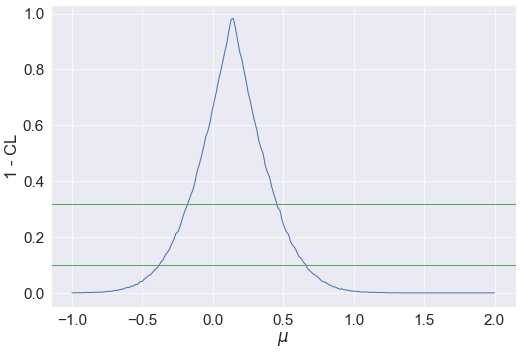

In [28]:
plt.figure(figsize=(12, 8), dpi=50)

plt.plot(mus, 1. - np.array(cls))

plt.xlabel(r"$\mu$")
plt.ylabel(r"1 - CL")
plt.axhline(1 - 0.9, c="g")
plt.axhline(1 - 0.68, c="g")

plt.show()

In [29]:
def calculate_cl_hat_sigma_from_likelihood_ratios(mu, sigma, X, boot=10000):
    X_toy = norm.rvs(size=(len(X), boot), loc=mu, scale=sigma)

    toy_likelihood = chi2.logpdf((len(X) - 1) * X_toy.std(axis=0) / sigma**2, df=len(X) - 1)
    true_likelihood = chi2.logpdf((len(X) - 1) * X.std() / sigma**2, df=len(X) - 1)
    cl = 1 - (toy_likelihood < true_likelihood).mean()
    return cl

In [30]:
mu = 0.2
sigmas = np.linspace(0.01, 4, 200)

cls = []
for sigma in tqdm(sigmas):
    cl = calculate_cl_hat_sigma_from_likelihood_ratios(mu=mu, sigma=sigma, X=X)
    cls.append(cl)

100%|██████████| 200/200 [00:01<00:00, 123.28it/s]


In [31]:
plt.plot(sigmas, 1. - np.array(cls))

plt.xlabel(r"$\hat\sigma$")
plt.ylabel(r"1 - CL")
plt.axhline(1 - 0.9, c="g")
plt.axhline(1 - 0.68, c="g")
plt.show()

In [33]:
def calculate_cl_from_likelihood_ratios(mu, sigma, X, boot=10000):
    X_toy = norm.rvs(size=(len(X), boot), loc=mu, scale=sigma)

    toy_likelihood_mu = norm.logpdf(X_toy.mean(axis=0), loc=mu, scale=sigma / np.sqrt(len(X)))
    true_likelihood_mu = norm.logpdf(X.mean(), loc=mu, scale=sigma / np.sqrt(len(X))) 
    
    toy_likelihood_sigma = chi2.logpdf((len(X) - 1) * X_toy.std(axis=0) / sigma**2, df=len(X) - 1)
    true_likelihood_sigma = chi2.logpdf((len(X) - 1) * X.std() / sigma**2, df=len(X) - 1) 
    
    cl = 1 - (toy_likelihood_mu * toy_likelihood_sigma > true_likelihood_mu * true_likelihood_sigma).mean()

    return cl

In [34]:
from collections import defaultdict

mus = np.linspace(-5, 5, 100)
sigmas = np.linspace(0.1, 10, 100)
MUS, SIGMAS = np.meshgrid(mus, sigmas)

cls = []
for mu, sigma in tqdm(list(zip(MUS.reshape(-1), SIGMAS.reshape(-1)))):
    cl = calculate_cl_from_likelihood_ratios(mu, sigma, X, boot=5000)
    cls.append(cl)

100%|██████████| 10000/10000 [01:00<00:00, 163.94it/s]


In [35]:
CLS = np.array(cls).reshape(*MUS.shape)

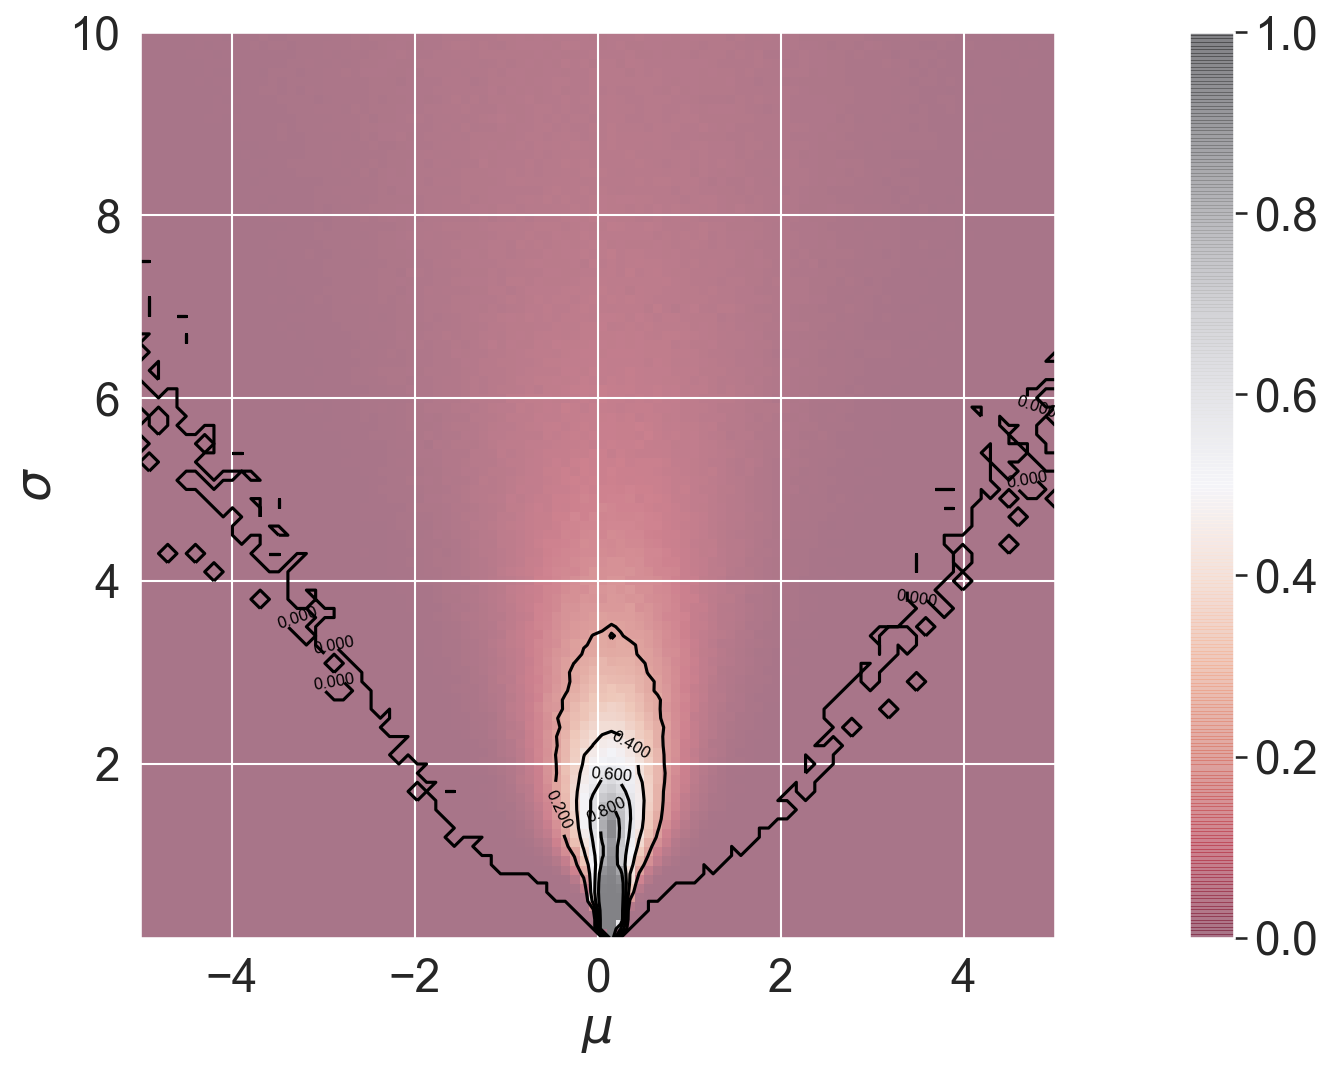

In [36]:
plt.figure(figsize=(23, 8), dpi=150)
contours = plt.contour(MUS, SIGMAS, 1 - CLS, 5, colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.imshow(
    1 - CLS, extent=[-5, 5, 0.1, 10], 
    origin='lower',
    cmap='RdGy', alpha=0.5
)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
plt.colorbar();

Про то как с помощью построения Неймана строить 1D-интервалы отправляю вас в замечательное путешествие по статьям :)

**Giovanni Punzi. “Ordering algorithms and confidence intervals in the presence
of nuisance parameters”. In: Statistical problems in particle physics, astrophysics
and cosmology. Proceedings of PHYSTAT05. Ed. by Louis Lyons and M¨uge
Karag¨oz Unel. Imperial College Press, 2006, p. 88.**